In [1]:
import os
os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"
os.environ["JAX_PLATFORM"] = "cpu"


import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")


from femsolver.jax_utils import auto_vmap, vmap
from femsolver.quadrature import quad_quad4, shape_fn_quad4, quad_tri3, shape_fn_tri3
from femsolver.operator import FemOperator
import jax.numpy as jnp

import matplotlib.pyplot as plt


In [2]:
jax.__version__

'0.4.30'

In [3]:
def compute_energy(u_grad):
    F = u_grad + jnp.eye(2)
    return 1.0

In [4]:
nodes = jnp.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])
quad_elements = jnp.array([[0, 1, 4, 3]])
tri_elements = jnp.array([[1, 2, 4], [2, 5, 4]])

In [5]:
shapes = {
    1: FemOperator(quad_quad4, shape_fn_quad4, compute_energy),
    2: FemOperator(quad_tri3, shape_fn_tri3, compute_energy),
}

In [6]:
u = jnp.zeros((6, 2))
cell_types = jnp.array([1, 2])

In [7]:
qs, w = shapes[1].funcs["quads"]()

In [8]:
shapes[1].interpolate(qs, u[quad_elements[0]])

Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float64)

In [9]:
shapes[1].interpolate(qs, nodes[quad_elements[0]])

Array([[0.21132487, 0.21132487],
       [0.78867513, 0.21132487],
       [0.21132487, 0.78867513],
       [0.78867513, 0.78867513]], dtype=float64)

In [10]:
qs, w = shapes[2].funcs["quads"]()
shapes[2].interpolate(qs, nodes[tri_elements])

Array([[[1.33333333, 0.33333333],
        [1.66666667, 0.66666667]]], dtype=float64)

In [11]:
shapes[1].interpolate_cells(qs, u[quad_elements])

Array([[[0., 0.]]], dtype=float64)

In [12]:
shapes[1].gradient_over_cells(qs, u[quad_elements], nodes[quad_elements])

Array([[[[0., 0.],
         [0., 0.]]]], dtype=float64)

In [14]:
shapes[1].integrate(u[quad_elements], nodes[quad_elements])

Array([1.], dtype=float64)

In [15]:
u_scalar = jnp.ones(6)

In [16]:
u_scalar[quad_elements].shape

(1, 4)

In [25]:
jnp.sum(shapes[1].integrate(u_scalar[quad_elements], nodes[quad_elements]))

Array(1., dtype=float64)

In [26]:
jnp.sum(shapes[2].integrate(u_scalar[tri_elements], nodes[tri_elements]))

Array(1., dtype=float64)

In [42]:
import matplotlib.pyplot as plt


# --- Material model (linear elasticity: plane strain) ---
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


def compute_stress(eps, mu=1.0, lmbda=1.0):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


def linear_elasticity_energy(grad_u, mu=1.0, lmbda=1.0):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)


def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# --- Mesh generation ---
def generate_unit_square_mesh_tri(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)


# --- Solver ---
def solve_fem():
    # --- Mesh ---
    coords, elements = generate_unit_square_mesh_tri(4, 2)
    n_nodes = coords.shape[0]
    n_dofs = 2 * n_nodes
    u = jnp.zeros(n_dofs)

    fem = FemOperator(
        compute_quads=quad_tri3,
        compute_shape_fn=shape_fn_tri3,
        compute_energy=linear_elasticity_energy,
    )


    # --- Total energy ---
    def total_energy(u_flat, coords, elements, fem):
        u = u_flat.reshape(-1, 2)
        u_cell = u[elements]
        x_cell = coords[elements]
        return jnp.sum(fem.integrate(u_cell, x_cell))

    grad_E = jax.grad(total_energy)
    hess_E = jax.jacfwd(jax.grad(total_energy))
    K = hess_E(u, coords, elements, fem)
    f_int = grad_E(u, coords, elements, fem)

    # Apply Dirichlet BCs
    left_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0))[0]
    right_nodes = jnp.where(jnp.isclose(coords[:, 0], 1.0))[0]
    fixed_dofs = jnp.concatenate(
        [
            2 * left_nodes,
            2 * left_nodes + 1,
            2 * right_nodes,
        ]
    )
    prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.1)
    free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

    f_ext = -f_int - K @ prescribed_values
    f_reduced = f_ext[free_dofs]
    K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
    u_free = jnp.linalg.solve(K_reduced, f_reduced)
    u_full = prescribed_values.at[free_dofs].set(u_free)

    return coords, u_full.reshape(-1, 2), elements


# --- Compute von Mises stress per element ---
def compute_element_stress(coords, u, elements, fem):
    u_cells = u.reshape(-1, 2)[elements]
    coords_cells = coords[elements]

    def element_von_mises(u_e, x_e):
        qp, _ = quad_tri3()
        xi = qp[0]  # just take one point per element
        grad_u = fem.gradient(xi, u_e, x_e)
        eps = compute_strain(grad_u)
        sigma = compute_stress(eps)
        return von_mises_stress(sigma)

    return jax.vmap(element_von_mises)(u_cells, coords_cells)


# --- Visualization ---
def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.figure(figsize=(10, 5))
    plt.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap="viridis",
    )
    plt.colorbar(label="Von Mises Stress")
    plt.title("Von Mises Stress on Deformed Mesh")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

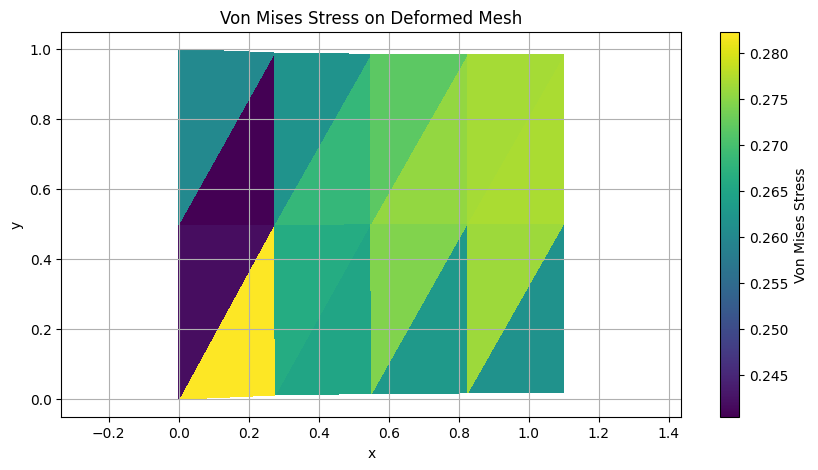

In [44]:
coords, u, elements = solve_fem()
fem = FemOperator(quad_tri3, shape_fn_tri3, linear_elasticity_energy)

stress_vm = compute_element_stress(coords, u, elements, fem)
plot_displacement_and_stress(coords, u, elements, stress_vm)
